In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from dataset import get_loaders
from models.doc import DOC

In [3]:
DEVICE="cuda"
WINDOW=32
BATCH_SIZE=32
LR=1e-4
EPOCHS=3
WEIGHT_DECAY=1e-6
LATENT_DIM=32

In [4]:
trainloader, testloader = get_loaders(root='data', window_size=WINDOW, batch_size=BATCH_SIZE)

In [5]:
model = DOC(input_dim=123, hidden_size=256, latent_dim=LATENT_DIM, num_layers=4, bidirectional=True).to(DEVICE)

In [6]:
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=0.1)

In [7]:
# Init center
model.eval()

n_samples = 0
eps=0.1
c = torch.zeros(LATENT_DIM).to(DEVICE)

model.eval()
with torch.no_grad():
    for x, y in tqdm(trainloader):
        x = x.to(DEVICE)
        proj = model(x)
        n_samples += proj.shape[0]
        c += torch.sum(proj, dim=0)
c /= n_samples

c[(abs(c) < eps) & (c < 0)] = -eps
c[(abs(c) < eps) & (c > 0)] = eps

100%|██████████| 24517/24517 [01:11<00:00, 342.69it/s]


In [8]:
model.train()

pbar = range(EPOCHS)
for epoch in pbar:
        
    curr_loss = 0
    for x, target in tqdm(trainloader):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        proj = model(x)
        dist = torch.sum((proj - c) ** 2, dim=1)
        loss = torch.mean(dist)
        curr_loss+=loss.item()
            
        loss.backward()
        optimizer.step()

    scheduler.step()
    print(f"For epoch {epoch+1}/{EPOCHS} ; loss : {curr_loss/len(trainloader)}")
    

checkpoint = {"state_dict":model.state_dict(), 'center':c.detach().cpu()}
torch.save(checkpoint, 'checkpoints/doc.pkl')

100%|██████████| 24517/24517 [04:32<00:00, 90.05it/s]


For epoch 1/3 ; loss : 0.005800602508879927


100%|██████████| 24517/24517 [04:30<00:00, 90.54it/s]


For epoch 2/3 ; loss : 1.5229896741449132e-05


100%|██████████| 24517/24517 [04:30<00:00, 90.47it/s]

For epoch 3/3 ; loss : 5.304579663940275e-06


In [9]:
test_proj = []
targets = []

model.eval()
with torch.no_grad():
    for x, target in tqdm(testloader):
        x = x.to(DEVICE)
        proj = model(x)
        test_proj.append(proj)
        targets.append(target)

test_proj = torch.cat(test_proj)
test_targets = torch.cat(targets)

test_dist = torch.sum((test_proj - c) ** 2, dim=1).cpu()
test_scores = - test_dist

100%|██████████| 5400/5400 [00:16<00:00, 335.03it/s]


In [44]:
results = pd.DataFrame({
    "scores":test_scores.cpu(),
    "labels":test_targets
})

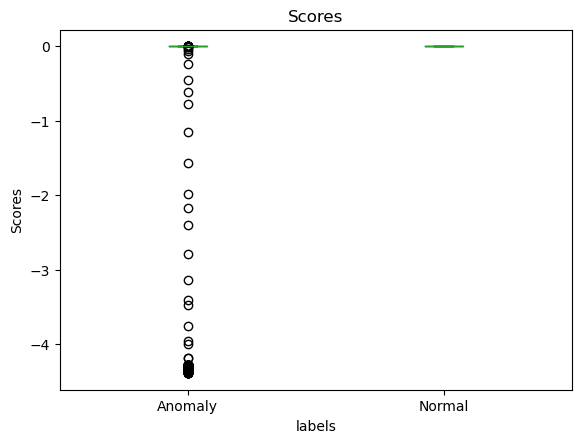

In [45]:
results.boxplot(column='scores', by='labels', grid=False)
plt.title('Scores')
plt.suptitle('')  # Remove the automatic title
plt.xticks(ticks=[1, 2], labels=['Anomaly', 'Normal'])
plt.ylabel('Scores')
plt.show()

In [52]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_targets, test_scores)
print("AUC Score: ", round(auc, 3))

AUC Score:  0.548
